# Problem Definition

The task is:

Using the Police UK API (Home | data.police.uk) extract the data related to `street-level crime` and `outcome` data as well as `the nearest police stations`.

Create a single database that will contain all the street level crime and outcome data with the nearest police station that have investigated the crimes and remove all the data that have a missing outcome while highlighting which authorities do not provide an outcome.

Present a sample of your data with the code and a brief document explaining your thought process for the technologies you have selected.

Main structure of this notebook is below:

| step | task | tools | notes |
|----------|----------|----------|----------|
| 1 | download data | `wget`,`police-api-client` | archived data|
| 2 | prepare data| `pandas`| read all .csv files from multiple folders |
| 3 | descriptive analysis | `pandas`,`police-api-client` | check missing values,columns |
| 4 | data vistualization | `plotly`, `cufflinks` | vistualise |
| 5 | propress data | `Python` | process data according to requirements|
| 6 | create database | `MySQLWorkbench` | create a database to store data|
| 7 | upload to database | `chimney` | upload  data to exisiting table |
| 8 | finalise | `MySQL` |  finalise ETL (Extraction, Transformation and )|

# 1. Load packages

In [10]:
!pip install police-api-client  pyarrow cukklinks glob -q

In [1]:
import json
import os
import glob
import pandas as pd
from tqdm.notebook import tqdm
import requests

# data.police.UK 
# https://github.com/rkhleics/police-api-client-python/
# pip install police-api-client -q
from police_api import PoliceAPI
api = PoliceAPI()

# database
from sqlalchemy import create_engine

# vistualization
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
# colab plot display
import plotly.io as pio

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

* Street-level crimes

Crimes at street-level; either within a 1 mile radius of a single point, or within a custom area.


* Street-level outcomes

Outcomes at street-level; either at a specific location, within a 1 mile radius of a single point, or within a custom area.

Note: Outcomes are not available for the Police Service of Northern Ireland.

* Crimes at a location

Returns just the crimes which occurred at the specified location, rather than those within a radius. If given latitude and longitude, finds the nearest pre-defined location and returns the crimes which occurred there.


# 1. Download Data

The simplest method is to download crime records directly from archive by specifing year and month.

The files on this page provide a complete snapshot of crime, outcome, and stop and search data, as held at a particular point in history. These archives were not being generated before December 2013.

https://data.police.uk/data/archive/

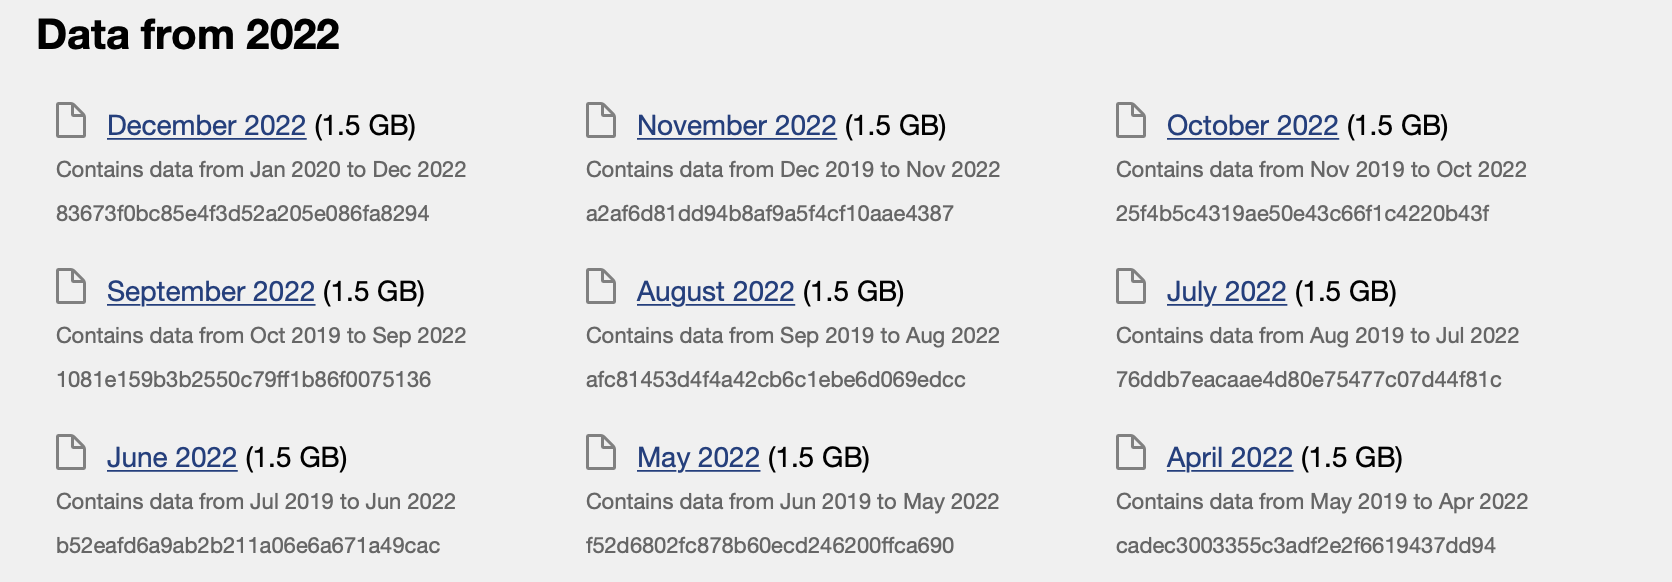

In [53]:
# use the api to get dates
dates = api.get_dates()
print(dates)

['2023-01', '2022-12', '2022-11', '2022-10', '2022-09', '2022-08', '2022-07', '2022-06', '2022-05', '2022-04', '2022-03', '2022-02', '2022-01', '2021-12', '2021-11', '2021-10', '2021-09', '2021-08', '2021-07', '2021-06', '2021-05', '2021-04', '2021-03', '2021-02', '2021-01', '2020-12', '2020-11', '2020-10', '2020-09', '2020-08', '2020-07', '2020-06', '2020-05', '2020-04', '2020-03', '2020-02']


This archive contains data from latest to January 2014.  Data from Dec 2010 to Dec 2013 can be downloaded via https://data.police.uk/data/archive/2023-01.zip


Example to download latest data

In [1]:
# download UK crime records from archive via `wget`
# It takes about 5mins and 

!wget 'https://data.police.uk/data/archive/2023-01.zip'

--2023-03-05 21:15:36--  https://data.police.uk/data/archive/2023-01.zip
Resolving data.police.uk (data.police.uk)... 52.50.201.33, 34.251.183.233
Connecting to data.police.uk (data.police.uk)|52.50.201.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://policeuk-data.s3.amazonaws.com/archive/2023-01.zip [following]
--2023-03-05 21:15:36--  https://policeuk-data.s3.amazonaws.com/archive/2023-01.zip
Resolving policeuk-data.s3.amazonaws.com (policeuk-data.s3.amazonaws.com)... 52.218.36.121, 52.218.44.41, 52.92.34.129, ...
Connecting to policeuk-data.s3.amazonaws.com (policeuk-data.s3.amazonaws.com)|52.218.36.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1656935214 (1.5G) [binary/octet-stream]
Saving to: ‘2023-01.zip’

2023-01.zip         100%[===================>]   1.54G  5.80MB/s    in 4m 47s  

2023-03-05 21:20:24 (5.50 MB/s) - ‘2023-01.zip’ saved [1656935214/1656935214]



# 2 Unzip and Read all .csv files

In [36]:
# unzip downloaded data to 'Desktop/UK_Police/'
!unzip /Users/jason/Desktop/UK_Police/2023-01.zip -d /Users/jason/Desktop/UK_Police/data/archive/ 

Archive:  /Users/jason/Desktop/UK_Police/2023-01.zip
  inflating: /Users/jason/Desktop/UK_Police/data/archive/2020-02/2020-02-avon-and-somerset-street.csv  
  inflating: /Users/jason/Desktop/UK_Police/data/archive/2020-02/2020-02-avon-and-somerset-outcomes.csv  
  inflating: /Users/jason/Desktop/UK_Police/data/archive/2020-02/2020-02-avon-and-somerset-stop-and-search.csv  
  inflating: /Users/jason/Desktop/UK_Police/data/archive/2020-02/2020-02-bedfordshire-street.csv  
  inflating: /Users/jason/Desktop/UK_Police/data/archive/2020-02/2020-02-bedfordshire-outcomes.csv  
  inflating: /Users/jason/Desktop/UK_Police/data/archive/2020-02/2020-02-bedfordshire-stop-and-search.csv  
  inflating: /Users/jason/Desktop/UK_Police/data/archive/2020-02/2020-02-btp-street.csv  
  inflating: /Users/jason/Desktop/UK_Police/data/archive/2020-02/2020-02-btp-stop-and-search.csv  
  inflating: /Users/jason/Desktop/UK_Police/data/archive/2020-02/2020-02-cambridgeshire-street.csv  
  inflating: /Users/jason/

The unzip files contain three type of files of which names ends with `street`, `outcomes` and `stop-and-search`.

In [81]:
# specified folder path

folder_path = '/data/archive/2023-01'
folder = os.getcwd()+folder_path
print(folder)
suffix = 'street'
# use glob to get all the csv files in the folder
csv_files = glob.glob(os.path.join(folder, "*{s}.csv".format(s=suffix )))

/Users/jason/Desktop/UK_Police/data/archive/2023-01


In [36]:
# specified folder path

folder_path = '/data/archive/2023-01'
folder = os.getcwd()+folder_path
print(folder)
# use glob to get all the csv files in the folder
csv_files = glob.glob(os.path.join(folder, "*.csv"))

df = pd.DataFrame()
for f in tqdm(csv_files):
    file = pd.read_csv(f)
    df = pd.concat([file, df])

/Users/jason/Desktop/UK_Police/data/archive/2023-01


  0%|          | 0/116 [00:00<?, ?it/s]

In [8]:
# read outcomes file
df1 = pd.read_csv('data/archive/2020-02/2020-02-avon-and-somerset-outcomes.csv')
df1.head(1)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Outcome type
0,851ac53841d89ab2cfc4ccdcb543aecd84e9d173b147eb...,2020-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,NaN,NaN,No location,NaN,NaN,Unable to prosecute suspect


In [143]:
# read stop-and-search file
df2 = pd.read_csv('data/archive/2020-02/2020-02-avon-and-somerset-stop-and-search.csv')
df2.head(2)

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Vehicle search,2020-02-01T00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Person search,2020-02-01T00:10:00+00:00,NaN,NaN,NaN,NaN,Male,18-24,NaN,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,Arrest,False,False


In [144]:
df2.shape

(752, 15)

In [10]:
# read street-level crime file
df3 = pd.read_csv('data/archive/2020-02/2020-02-avon-and-somerset-street.csv')
df3.head(2)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,d3dc12297836c17e2a1f70b7b17a4002adc070656dd1f2...,2020-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.512773,51.411751,On or near Westfield Close,E01014399,Bath and North East Somerset 001A,Burglary,Status update unavailable,NaN
1,ab8cb1c81b5fa1c4ec741cb907822bd18873e68832b245...,2020-02,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.509126,51.416137,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Criminal damage and arson,Status update unavailable,NaN


By examing the result of `outcomes`, `street` and `stop-and-search` files, I find that `outcomes` and `street` files are the data required and they share the same column `Crime ID` with unique id which can be used as key to merge.

In [2]:
import progressbar
progress = progressbar.ProgressBar()

# define a function to read all files from working directory and its subfolders \
# given the input 'street', 'outcomes' or 'stop-and-research'
def read_files(suffix):
    # specified folder path
    folder = os.getcwd()+'/data/archive'
    # get subfolder names
    sub_folders = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]

    dataset = pd.DataFrame()
    for i in tqdm(sub_folders):
        folder_path = '/data/archive/{}'.format(i)
        folder = os.getcwd()+folder_path
        # use glob to get all the csv files name in the folder
        csv_files = glob.glob(os.path.join(folder, "*{s}.csv".format(s=suffix)))

        df = pd.DataFrame()
        for f in tqdm(csv_files):
            file = pd.read_csv(f)
            # merge all files in a single folder
            df = pd.concat([file, df])
        # merge files all all folder   
        dataset = pd.concat([df, dataset])
    return dataset
    

In [3]:
# read all street lever crimes
df_street = read_files('street')

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

In [35]:
df_street.shape

(18861545, 12)

In [5]:
# read all Street-level outcomes files
df_outcomes = read_files('outcomes')

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [91]:
df_outcomes.head(1)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Outcome type
0,e09f5c8e9fafdfade235393abbbcfffec971f442f216f1...,2020-11,Lincolnshire Police,Lincolnshire Police,-0.557617,53.234437,On or near FLEET STREET,E01026144,Lincoln 003B,Investigation complete; no suspect identified


In [36]:
df_outcomes.shape

(13314668, 10)

Merge street-level crimes and outcome dataframe

In [26]:
# identical columns in street-level crime and outcomes
intersection_col = list(set(df_outcomes.columns).intersection(set(df_street.columns)))
intersection_col 

['Falls within',
 'LSOA name',
 'Location',
 'Longitude',
 'LSOA code',
 'Month',
 'Latitude',
 'Reported by',
 'Crime ID']

In [62]:
# merge street level 
df_street_outcome = pd.merge(df_street, df_outcomes, on=intersection_col,how='left')

In [72]:
df_street_outcome['Outcome type'].unique()

array([nan, 'Investigation complete; no suspect identified',
       'Suspect charged', 'Local resolution', 'Offender given a caution',
       'Unable to prosecute suspect',
       'Offender given a drugs possession warning',
       'Formal action is not in the public interest',
       'Further investigation is not in the public interest',
       'Offender given penalty notice',
       'Action to be taken by another organisation',
       'Further action is not in the public interest',
       'Suspect charged as part of another case'], dtype=object)

In [104]:
# save to local path
df_street_outcome.to_csv('data/uk_crime_archive_2023_01_street_outcomes.csv')

# 3. Descriptive Analysis

This unzip dataset with full size can be downloaded [HERE](https://drive.google.com/file/d/1EwEmsVVKXPf94GJFQ0_p6R6_3jz5-d21/view?usp=share_link)

The size of this dataset is 18,943,324, which is too big, for demostration purpose, I random select 1 million entries, which can be download [HERE](https://drive.google.com/file/d/1NZq7b11cwJyIn3HdQx173vJ3Xm2RDDi_/view?usp=share_link)

In [2]:
%%time
# read merged data 
# pyarrow will accelerate reading files
data = pd.read_csv('data/uk_crime_archive_2023_01_street_outcomes_1M.csv',engine="pyarrow", index_col=0)

CPU times: user 921 ms, sys: 204 ms, total: 1.13 s
Wall time: 519 ms


In [3]:
data.shape

(1000000, 13)

In [4]:
data.head(1)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Outcome type
,,,,,,,,,,,,,
18943213,3349bb5beb26986dfe1533421d3511d02de0de5e3d30e4...,2020-06,North Yorkshire Police,North Yorkshire Police,-1.048775,53.941721,On or near West Moor Lane,E01013378,York 023B,Bicycle theft,Investigation complete; no suspect identified,None,


In [5]:
# data shape
data.shape

(1000000, 13)

In [6]:
# display columns name
data.columns

Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type',
       'Last outcome category', 'Context', 'Outcome type'],
      dtype='object')

In [7]:
# sort month in descending order
data.sort_values(['Month'], ascending = False, inplace = True)

In [8]:
# crime months
print(list(data.Month.unique()))

['2023-01', '2022-12', '2022-11', '2022-10', '2022-09', '2022-08', '2022-07', '2022-06', '2022-05', '2022-04', '2022-03', '2022-02', '2022-01', '2021-12', '2021-11', '2021-10', '2021-09', '2021-08', '2021-07', '2021-06', '2021-05', '2021-04', '2021-03', '2021-02', '2021-01', '2020-12', '2020-11', '2020-10', '2020-09', '2020-08', '2020-07', '2020-06', '2020-05', '2020-04', '2020-03', '2020-02']


We can see that the `Month` ranges from 2020-02 to 2023-01.

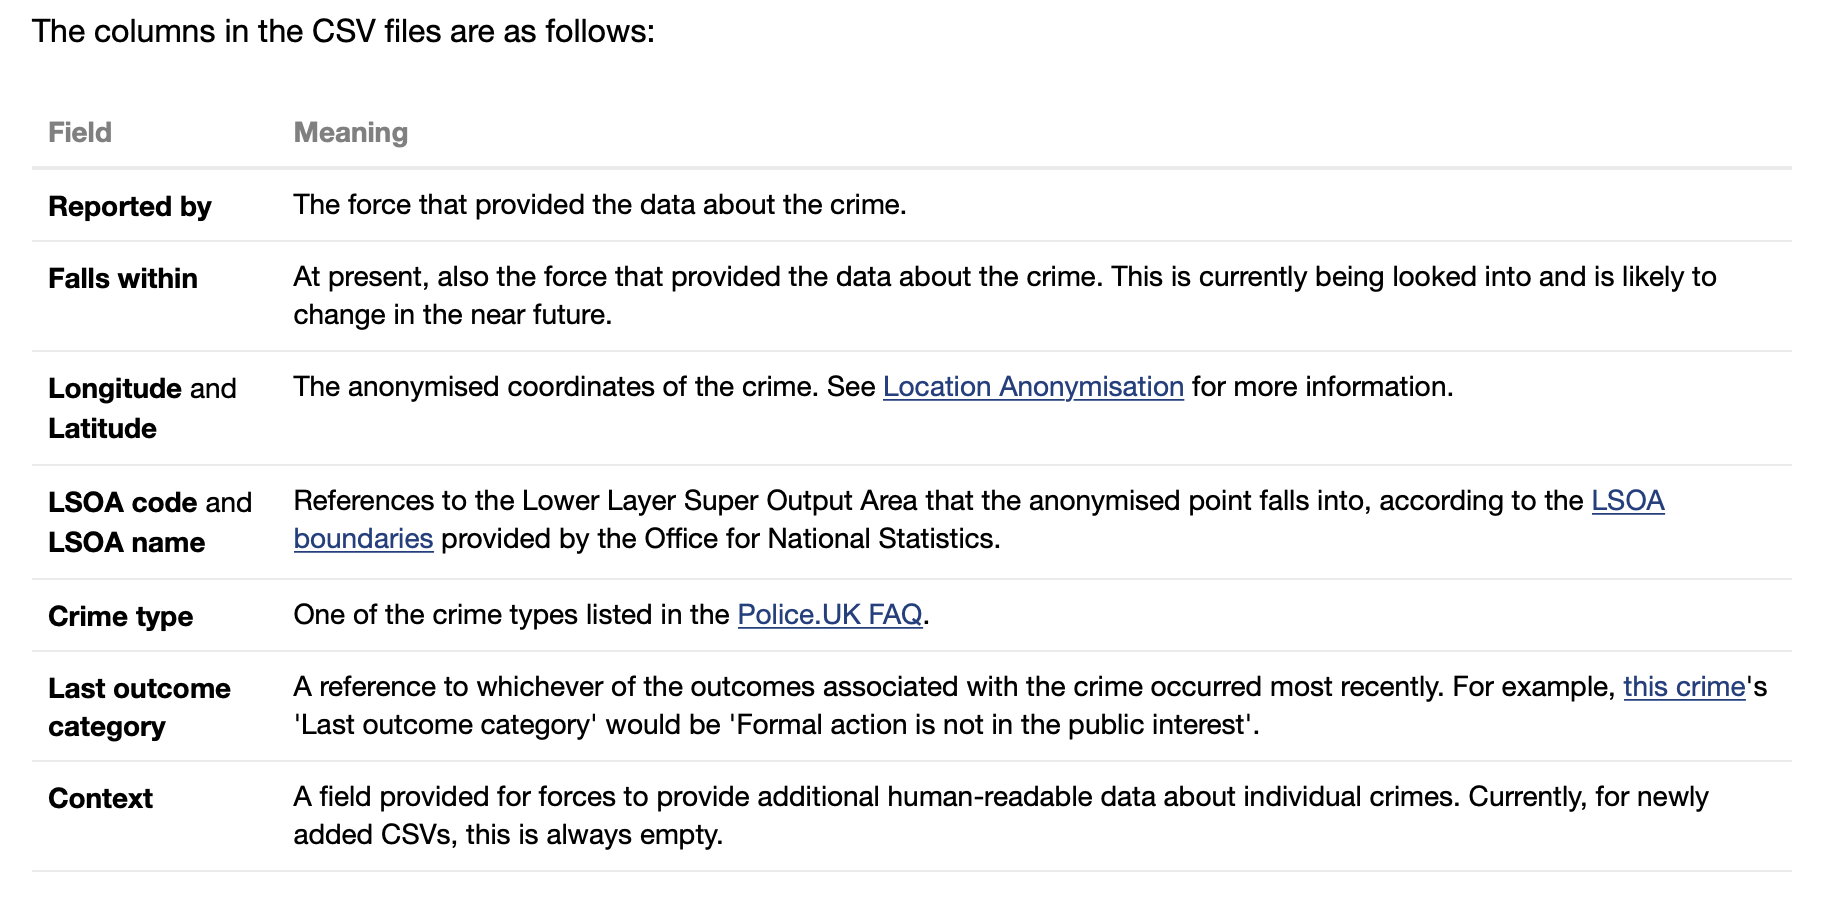

In [9]:
# display first ten locations
list(data.Location.unique())[:10]

['On or near ',
 'On or near Back Holywell Lane',
 'On or near The Mount',
 'On or near Elmbridge Road',
 'On or near Tyrwhitt Road',
 'On or near Francis Street',
 'On or near Midland Street',
 "On or near Miller'S Bridge",
 'On or near Cranwell Grove',
 'On or near Warren Road']

columns `Location` contains the street name

In [10]:
# check null value
data.isnull().sum()

Crime ID                       0
Month                          0
Reported by                    0
Falls within                   0
Longitude                  17054
Latitude                   17054
Location                       0
LSOA code                      0
LSOA name                      0
Crime type                     0
Last outcome category          0
Context                  1000000
Outcome type                   0
dtype: int64

In [11]:
# display first ten `Falls within`
list(data['Falls within'].unique())[:10]

['Metropolitan Police Service',
 'West Yorkshire Police',
 'Staffordshire Police',
 'Thames Valley Police',
 'Gloucestershire Constabulary',
 'Surrey Police',
 'Lincolnshire Police',
 'South Wales Police',
 'Derbyshire Constabulary',
 'Merseyside Police']

Columns `Falls within`  is nearest police station.

In [12]:
# unique Outcome
list(data['Outcome type'].unique())

['',
 'Investigation complete; no suspect identified',
 'Unable to prosecute suspect',
 'Local resolution',
 'Suspect charged',
 'Action to be taken by another organisation',
 'Further action is not in the public interest',
 'Further investigation is not in the public interest',
 'Formal action is not in the public interest',
 'Offender given penalty notice',
 'Offender given a caution',
 'Suspect charged as part of another case',
 'Offender given a drugs possession warning']

* We can see that although `Outcome type` has no `nan` values, it contains empty string.

In [13]:
# drop duplicates in Crime ID
data.drop_duplicates(subset=['Crime ID'],inplace=True)

In [14]:
data.shape

(760352, 13)

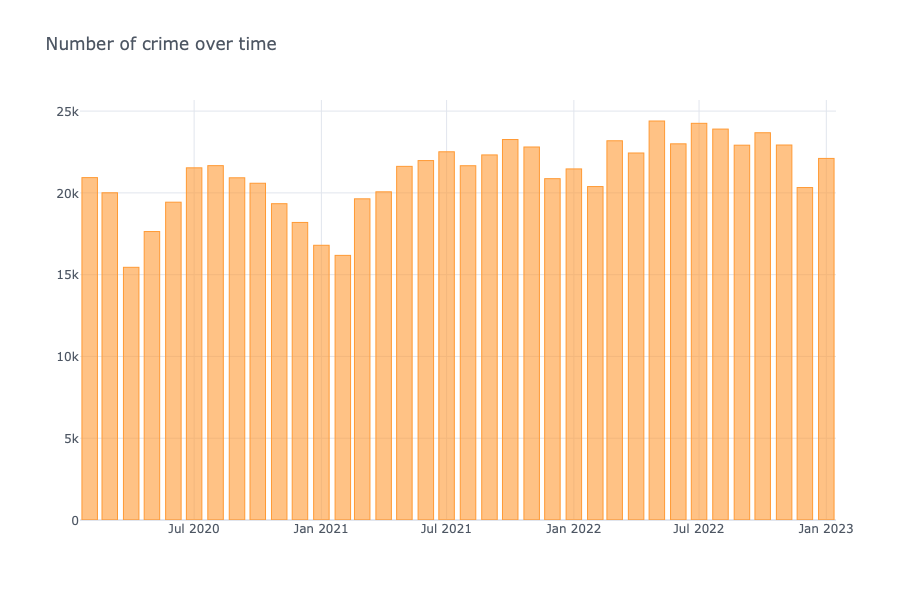

In [15]:
# Number of crime over time
pd.DataFrame(data.groupby(['Month'])['Crime ID'].count()).iplot(kind='bar',title='Number of crime over time')

In [16]:
data.shape

(760352, 13)

# 4. Remove all the data that have a missing outcome

to Create a single database that will contain all the street level crime and outcome data with the nearest police station that have investigated the crimes and remove all the data that have a missing outcome while highlighting which authorities do not provide an outcome.


In [17]:
# recall column names
data.columns

Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type',
       'Last outcome category', 'Context', 'Outcome type'],
      dtype='object')

 Columns `Location` contains street names.

In [18]:
list(data['Outcome type'].unique())

['',
 'Investigation complete; no suspect identified',
 'Unable to prosecute suspect',
 'Local resolution',
 'Suspect charged',
 'Action to be taken by another organisation',
 'Further action is not in the public interest',
 'Further investigation is not in the public interest',
 'Formal action is not in the public interest',
 'Offender given penalty notice',
 'Offender given a caution',
 'Suspect charged as part of another case',
 'Offender given a drugs possession warning']

Although the `data.isnull().sum()` shows zero on columns `Outcome`, we can see that the unique values of `Outcome` contains empty string which indicats missing values.

 if `Outcome type` is empty `missing_outcome` returns yes, else returns no.

In [19]:
data['missing_outcome'] = data['Outcome type'].apply(lambda x : 'yes' if (not x.strip()) else 'no')

In [20]:
# chenk the value of 'Outcome type' and 'missing_outcome' when 'missing_outcome == "no"'
data.query('missing_outcome == "no"').head(1)[['Outcome type','missing_outcome']]

,Outcome type,missing_outcome
,,
1432301,Investigation complete; no suspect identified,no


In [21]:
# chenk the value of 'Outcome type' and 'missing_outcome' when 'missing_outcome == "yes"'
data.query('missing_outcome == "yes"').head(1)[['Outcome type','missing_outcome']]

,Outcome type,missing_outcome
,,
1290965,,yes


We can see that when `missing_outcome` is 'yes', `Outcome type` is empty. There drop missing outcomes.

In [22]:
data.shape

(760352, 14)

In [23]:
data.head(1)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Outcome type,missing_outcome
,,,,,,,,,,,,,,
1290965,,2023-01,Metropolitan Police Service,Metropolitan Police Service,-0.136579,51.517476,On or near,E01004763,Westminster 013B,Anti-social behaviour,,None,,yes


# 5. Highlighting which authorities do not provide an outcome

Create a column named `Authority no outcome` to highlight which authorities do not provide an outcome

If `missing_outcome` is yes,  `Authority no outcome` returns the values of`Reported by`, else returns empty string, where `Reported by` is authorities names. 

The column `Reported by` is authority which reports crime records.

In [24]:
data['Reported by'].unique()

array(['Metropolitan Police Service', 'West Yorkshire Police',
       'Staffordshire Police', 'Thames Valley Police',
       'Gloucestershire Constabulary', 'Surrey Police',
       'Lincolnshire Police', 'South Wales Police',
       'Derbyshire Constabulary', 'Merseyside Police',
       'West Midlands Police', 'Dorset Police', 'Cleveland Police',
       'Gwent Police', 'Northumbria Police', 'Leicestershire Police',
       'Kent Police', 'Sussex Police', 'Northamptonshire Police',
       'Lancashire Constabulary', 'Nottinghamshire Police',
       'Hertfordshire Constabulary', 'South Yorkshire Police',
       'Avon and Somerset Constabulary', 'Warwickshire Police',
       'Durham Constabulary', 'Bedfordshire Police', 'West Mercia Police',
       'Humberside Police', 'Cheshire Constabulary', 'North Wales Police',
       'Cambridgeshire Constabulary', 'Essex Police',
       'Hampshire Constabulary', 'Police Service of Northern Ireland',
       'North Yorkshire Police', 'Suffolk Constabular

In [25]:
%%time
data['Authority no outcome'] = data.apply(lambda x : x['Reported by'] if x['missing_outcome'] == 'yes' else '', axis=1)

CPU times: user 2.75 s, sys: 44.4 ms, total: 2.8 s
Wall time: 2.8 s


In [26]:
data['Authority no outcome'].unique()

array(['Metropolitan Police Service', '', 'Staffordshire Police',
       'Gloucestershire Constabulary', 'Surrey Police',
       'Lincolnshire Police', 'Derbyshire Constabulary',
       'Merseyside Police', 'West Midlands Police', 'Dorset Police',
       'West Yorkshire Police', 'Leicestershire Police',
       'Lancashire Constabulary', 'Nottinghamshire Police',
       'Thames Valley Police', 'Avon and Somerset Constabulary',
       'Warwickshire Police', 'Durham Constabulary', 'Northumbria Police',
       'South Wales Police', 'Northamptonshire Police', 'Sussex Police',
       'North Wales Police', 'Essex Police', 'Hampshire Constabulary',
       'Cambridgeshire Constabulary',
       'Police Service of Northern Ireland', 'North Yorkshire Police',
       'Kent Police', 'Bedfordshire Police', 'Norfolk Constabulary',
       'Gwent Police', 'Humberside Police', 'South Yorkshire Police',
       'Dyfed-Powys Police', 'Cheshire Constabulary', 'Wiltshire Police',
       'Cleveland Police', 'H

In [27]:
# slice `Authority_no_outcome` and crime id
Authority_no_outcome = data[['Crime ID','Authority no outcome']]

In [30]:
Authority_no_outcome.shape

(760352, 2)

In [31]:
Authority_no_outcome.head(2)

,Crime ID,Authority no outcome
,,
1290965,,Metropolitan Police Service
1432301,ee83e0605c8790ddbbddcbc16f9ccc1c23b5ed6d6e6073...,


In [32]:
data.head(1)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Outcome type,missing_outcome,Authority no outcome
,,,,,,,,,,,,,,,
1290965,,2023-01,Metropolitan Police Service,Metropolitan Police Service,-0.136579,51.517476,On or near,E01004763,Westminster 013B,Anti-social behaviour,,None,,yes,Metropolitan Police Service


In [33]:
# drop Authority no outcome
data.drop(['Authority no outcome'], axis=1, inplace=True)

In [34]:
data.shape

(760352, 14)

* The Polices stations and Constabulary above are authorities that do not provide an outcome.

The column `Outcome type` is the outcome of investigation, removing missing outcome entries will also keep investigated crimes.

In [35]:
# query entries where missing_outcome is "no"
data = data.query('missing_outcome == "no"')

In [37]:
data.shape

(123065, 14)

In [38]:
data.head(1)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Outcome type,missing_outcome
,,,,,,,,,,,,,,
1432301,ee83e0605c8790ddbbddcbc16f9ccc1c23b5ed6d6e6073...,2023-01,West Yorkshire Police,West Yorkshire Police,-1.485493,53.855287,On or near Back Holywell Lane,E01011649,Leeds 022B,Violence and sexual offences,Investigation complete; no suspect identified,None,Investigation complete; no suspect identified,no


Drop `missing_outcome` column and  `Authority no outcome` with all outcomes

In [39]:
data.drop(['missing_outcome'], axis=1, inplace=True)

In [40]:
data.head(1)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Outcome type
,,,,,,,,,,,,,
1432301,ee83e0605c8790ddbbddcbc16f9ccc1c23b5ed6d6e6073...,2023-01,West Yorkshire Police,West Yorkshire Police,-1.485493,53.855287,On or near Back Holywell Lane,E01011649,Leeds 022B,Violence and sexual offences,Investigation complete; no suspect identified,None,Investigation complete; no suspect identified


In [41]:
data.shape

(123065, 13)

In [42]:
Authority_no_outcome.shape

(760352, 2)

In [43]:
# Merge the data with Authority_no_outcome 
data = pd.merge(data,Authority_no_outcome, on=['Crime ID'], how = 'left')

In [44]:
data.head(1)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Outcome type,Authority no outcome
0,ee83e0605c8790ddbbddcbc16f9ccc1c23b5ed6d6e6073...,2023-01,West Yorkshire Police,West Yorkshire Police,-1.485493,53.855287,On or near Back Holywell Lane,E01011649,Leeds 022B,Violence and sexual offences,Investigation complete; no suspect identified,None,Investigation complete; no suspect identified,


In [45]:
data.shape

(123065, 14)

# 6. The nearest police stations

The colomn `Falls within` contians `Police` and `Constabulary`. For example , I think both of 'Kent Police' and 'Derbyshire Constabulary' belong to police stations.

In [47]:
data['Falls within'].unique()

array(['West Yorkshire Police', 'Thames Valley Police',
       'South Wales Police', 'Derbyshire Constabulary',
       'Cleveland Police', 'West Midlands Police', 'Gwent Police',
       'Northumbria Police', 'Metropolitan Police Service', 'Kent Police',
       'Sussex Police', 'Northamptonshire Police',
       'Nottinghamshire Police', 'Hertfordshire Constabulary',
       'South Yorkshire Police', 'Leicestershire Police',
       'Lincolnshire Police', 'Bedfordshire Police', 'Merseyside Police',
       'West Mercia Police', 'Humberside Police', 'Cheshire Constabulary',
       'Surrey Police', 'Cambridgeshire Constabulary',
       'Lancashire Constabulary', 'Gloucestershire Constabulary',
       'Suffolk Constabulary', 'Durham Constabulary',
       'Hampshire Constabulary', 'Staffordshire Police', 'Essex Police',
       'Avon and Somerset Constabulary', 'Dyfed-Powys Police',
       'North Wales Police', 'Warwickshire Police',
       'North Yorkshire Police', 'Wiltshire Police',
       'N

In [48]:
# save to local
data.to_csv('data/uk_crime_archive_2023_01_street_outcomes_transformed_1M.csv')

# 7. Create database

create a database named `DataPoliceUK` to store UK Police data on server

`create database DataPoliceUK;`  # Syntax is in MySQL

Upload police data to database `DataPoliceUK` using Pyhton and `chimney` package

In [240]:
from sqlalchemy import create_engine
#!pip install mysql-connector-python

# 8. Upload crime data to database 

In [238]:
# config credential
USRNAME  = 'root'           # database usename     
PWD      = '15821828225Lzx' # database password
HOSTNAME = 'localhost'      # database hostname
PORT     =  3306            # database port
DATABASE = 'DataPoliceUK'   # database name
engine   = create_engine('mysql://{username}:{password}@{hostname}:{port}/{database}'.format(
                            username = USRNAME,
                            password = PWD,
                            port     = PORT,
                            hostname = HOSTNAME,
                            database = DATABASE))

Upload the  data to table `StreetLevelCrimeOutcome` in database `DataPoliceUK`

* upload data to database `DataPoliceUK` table `StreetLevelCrimeOutcome`, 
if this table already exist, append to it, else create a table named `StreetLevelCrimeOutcome`

In [239]:
# upload to database
data.to_sql('StreetLevelCrimeOutcome', con=engine, if_exists='append', index=False)

2244205

Example to query sample crime data on MySQLWorkBench

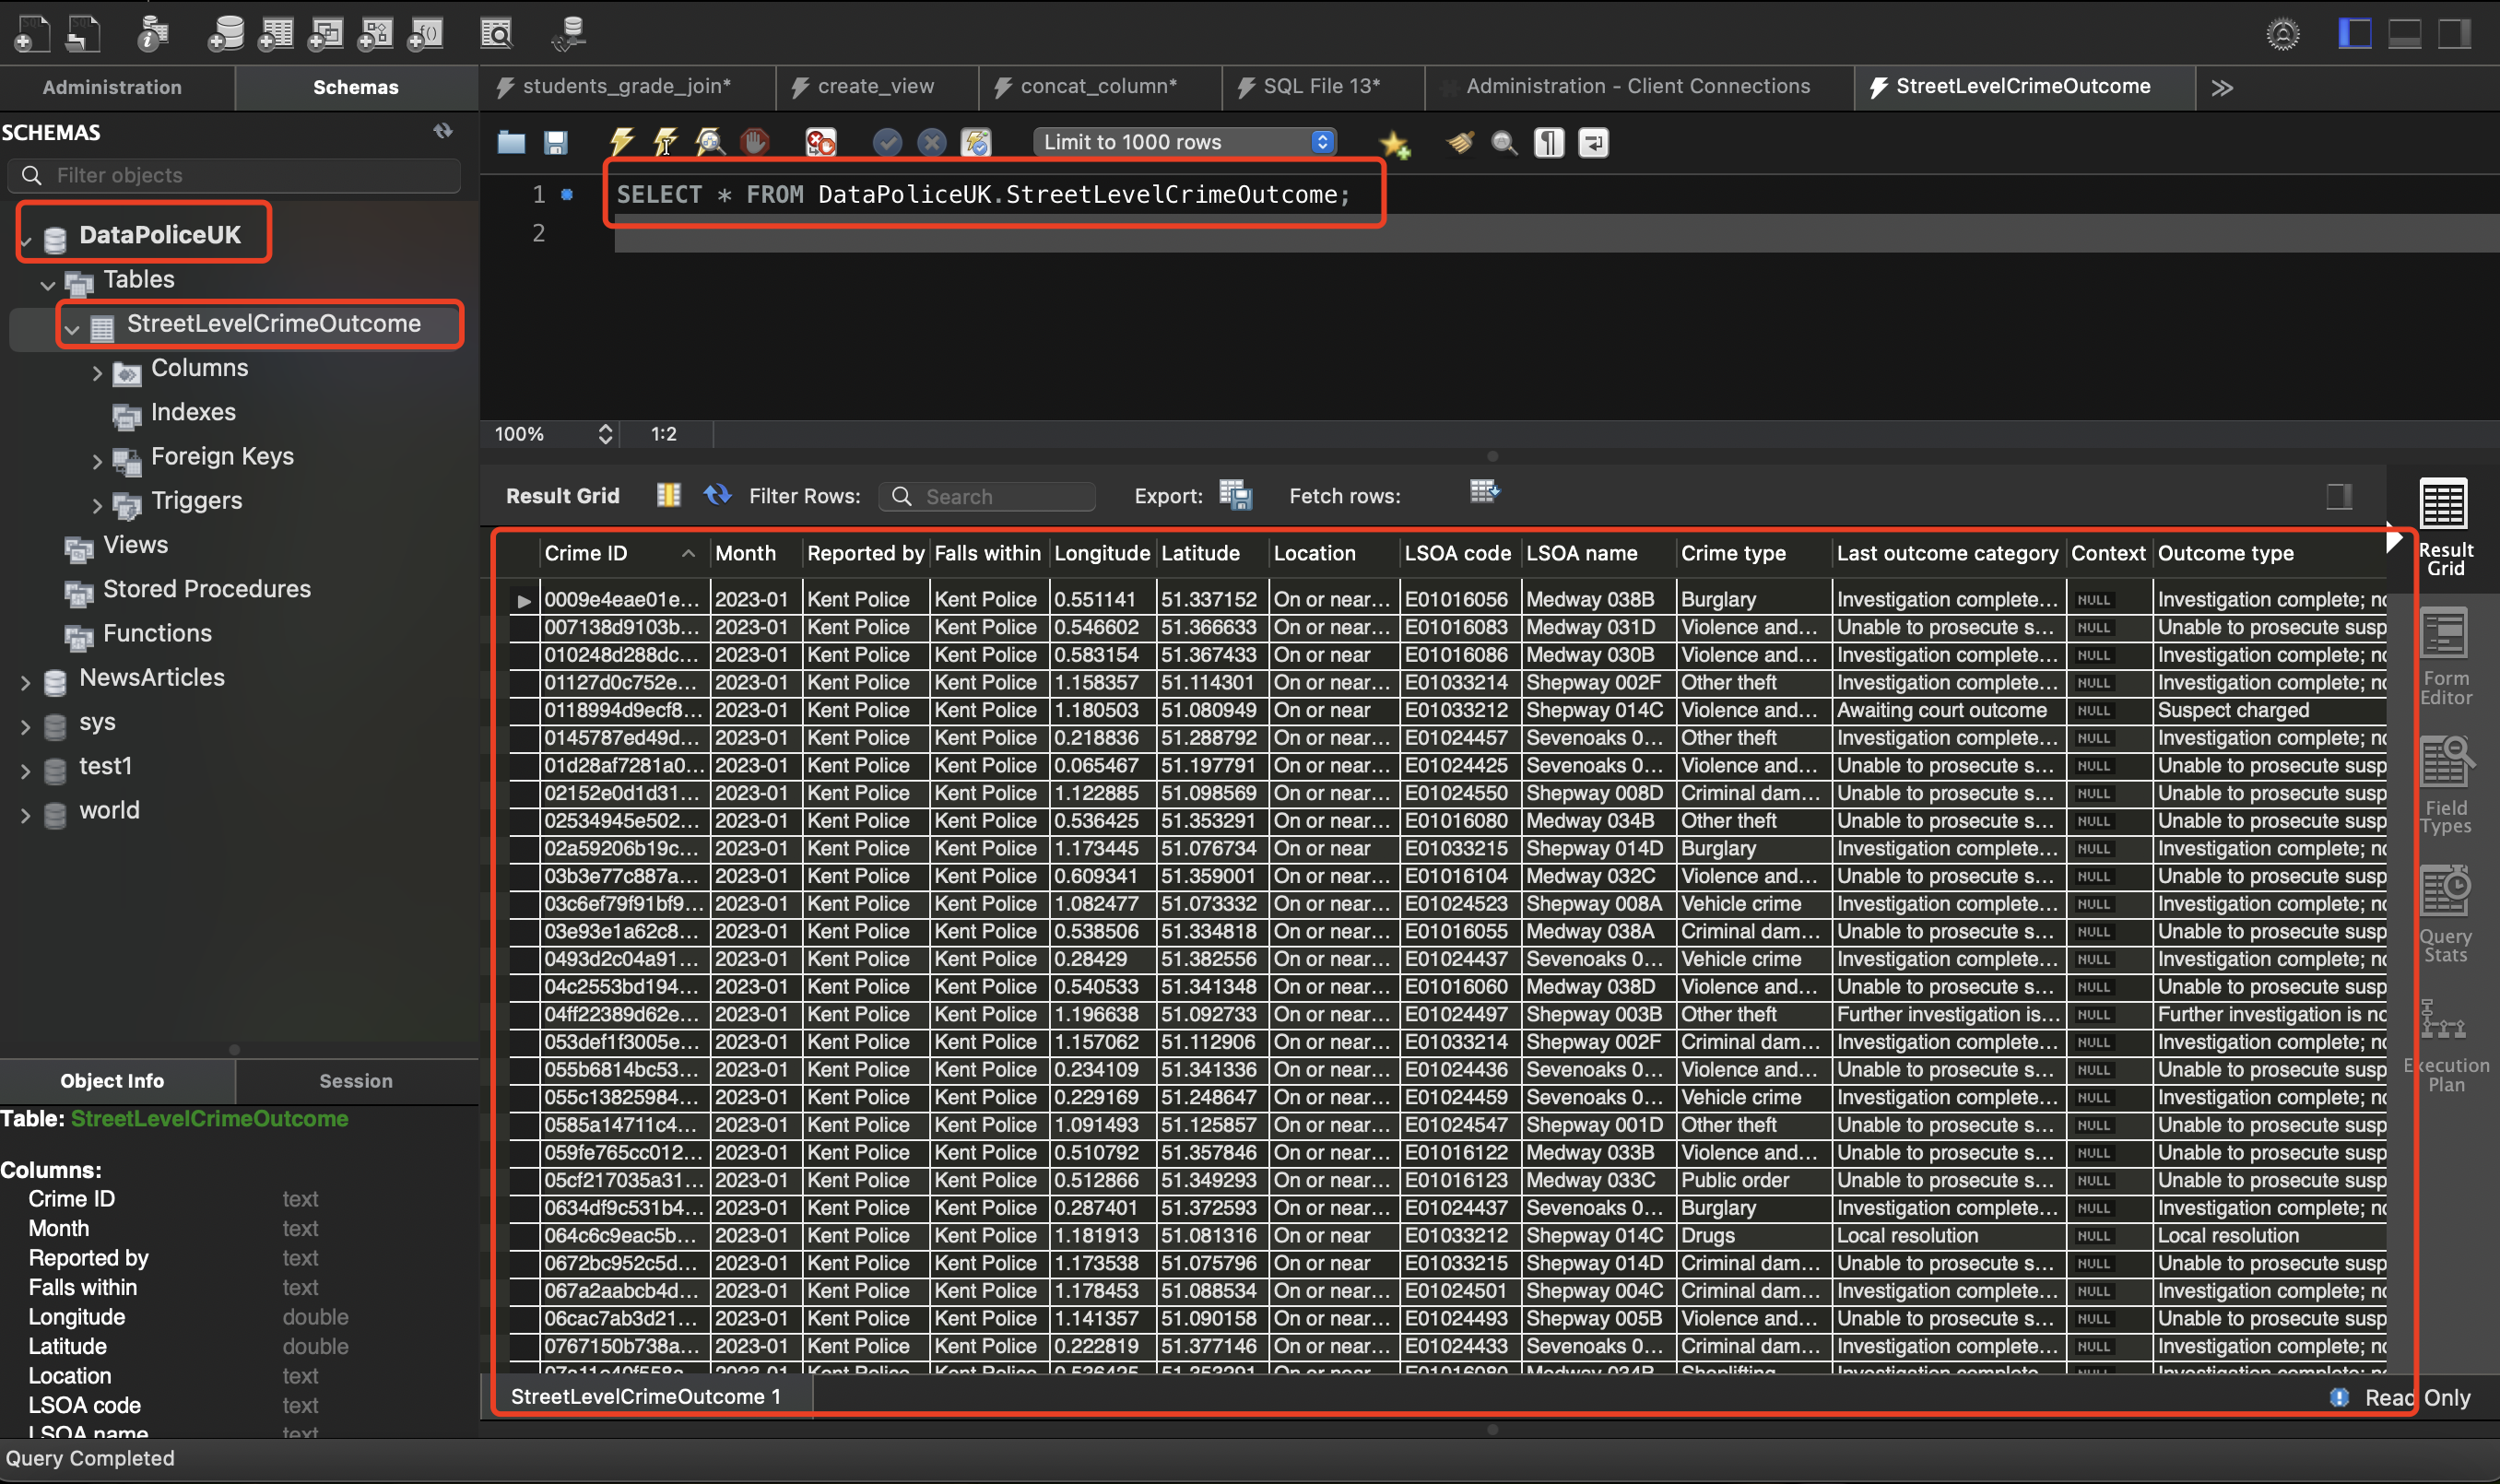

# 9 Finalise 

In this section I will finalise all Python codes from extracting, transforming and loading data.

Import Libraries

In [241]:
import os
import glob
import pandas as pd

# data.police.UK 
# https://github.com/rkhleics/police-api-client-python/
# pip install police-api-client -q
from police_api import PoliceAPI
api = PoliceAPI()

import progressbar
progress = progressbar.ProgressBar()
# database

from sqlalchemy import create_engine

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

'/Users/jason/Desktop/UK_Police'

## 9.1 Extract

In [244]:
# os.getcwd() # get working directory

# download the latest crime data to working directory
!wget 'https://data.police.uk/data/archive/latest.zip'

# unzip files to `/data/archive/`
!unzip <your working directory>/latest.zip -d <your working directory>/data/archive/

## 9.2 Transform

This section is to
* read and merge street-level crime and outcomes, 
* drop duplicates entries, 
* remove entries with missing outcomes,
* identify the nearest police station,
* highlight authorities that do not provide an outcome.


In [245]:
# define a function to read unzip csv files
def read_files(suffix):
    # specified folder path
    folder = os.getcwd()+'/data/archive'
    # get subfolder names
    sub_folders = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]

    dataset = pd.DataFrame()
    for i in progress(sub_folders):
        folder_path = '/data/archive/{}'.format(i)
        folder = os.getcwd()+folder_path
        # use glob to get all the csv files name in the folder
        csv_files = glob.glob(os.path.join(folder, "*{s}.csv".format(s=suffix)))

        df = pd.DataFrame()
        for f in tqdm(csv_files):
            file = pd.read_csv(f)
            # merge all files in a single folder
            df = pd.concat([file, df])
        # merge files all all folder   
        dataset = pd.concat([df, dataset])
    return dataset

# read all street lever crimes
df_street = read_files('street')

# read all Street-level outcomes files
df_outcomes = read_files('outcomes')

# merge street level crime and outcomes
data = pd.merge(df_street, df_outcomes, on=intersection_col,how='left')

# drop duplicates in Crime ID
data.drop_duplicates(subset=['Crime ID'],inplace=True)

# sort month in descending order
data.sort_values(['Month'], ascending = False, inplace = True)

# if Outcome type is empty, missing_outcome returns yes, else returns no.
data['missing_outcome'] = data['Outcome type'].apply(lambda x : 'yes' if ( not x.strip()) else 'no')

# If missing_outcome is yes,  Authority no outcome returns the values ofReported by, 
# else returns empty string, where Reported by is authorities names.

data['Authority no outcome'] = data.apply(lambda x : x['Reported by'] \
                                          if x['missing_outcome'] == 'yes' else '', axis=1)

# slice `Authority_no_outcome` and crime id
Authority_no_outcome = data[['Crime ID','Authority no outcome']]

# query entries where missing_outcome is "no" to remove entries without outcome
data = data.query('missing_outcome == "no"')

# drop temp column 'missing_outcome' and Authority no outcome with all possibile 
data.drop(['missing_outcome'], axis=1, inplace=True)
data.drop(['Authority no outcome'], axis=1, inplace=True)

# merge Authority_no_outcome to data
data = pd.merge(data,Authority_no_outcome, on=['Crime ID'], how = 'left')
# reset index
data.reset_index(drop=True, inplace=True)

# columns ['Falls within'] is the nearest police station

## 9.3 Load

Load transformed data into database `DataPoliceUK` table `StreetLevelCrimeOutcome`

In [ ]:
# config credential
USRNAME  = ''           # database usename     
PWD      = ''           # database password
HOSTNAME = ''           # database hostname
PORT     = ''           # database port
DATABASE = ''           # database name

# set pyhton sql engine
engine   = create_engine('mysql://{username}:{password}@{hostname}:{port}/{database}'.format(
                            username = USRNAME,
                            password = PWD,
                            port     = PORT,
                            hostname = HOSTNAME,
                            database = DATABASE))

# upload to database
data.to_sql('StreetLevelCrimeOutcome', con=engine, if_exists='append', index=False)